#### Motivation
Integrating artificial intelligence into medical research requires interdisciplinary collaborations, which imposes a barrier to early phase clinical studies or work by junior researcher. Two publications by Panch, T.(2019) and Rajkomar, A (2023) published in BMC Medicine, reiterated the difficulties in assembling clinical and machine learning experts for early phase project. Conducting robust efficacy and safety evaluation is more difficult with artificial intelligence [5,10].
##### Project Template
My chosen template is CM3050 Machine Learning and Neural Networks on “Deep Learning of a public dataset”.

Objectives:
- A simple jupyter notebook-based pipeline.
- Allow import of edf files. This allows import from EEG machine.
- Preprocessing includes segmenting time series, and value standardisation.
- Implementing two algorithms, a neural network and a non-neural network based algorithm.


[CHB-Mit Seizure Dataset.](https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset/data)

In [16]:
# Array and file access libraries
import numpy as np
import pandas as pd
import os
import importlib.util as util
from matplotlib import pyplot as plt



In [17]:
from scipy.signal import  welch, butter, filtfilt  # estimate signal power across all frequencies
import pywt # wavelet transformation algorithm. Python package to install is called PyWavelets

In [4]:
# SCIKIT learn library for preprocessing and optimisation search algorithm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split


In [5]:
# machine learning tensorflow library
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, LSTM, Dense, MaxPooling1D, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

#### Rapid prototyping
Uses CHM-MIT dataset, which has been preprocessed into Numpy arrays. Smaller size and has window segmentation of 1 second (Badea, 2021) [1].
This dataset provides
  - balanced samples of seizure and non-seizure classes.
  - and a second sample of non-balanced seizure and non-seizure classes from the original raw data proportion.
> Balanced dataset is used for this section (rapid prototyping)

In [6]:
for root, dirs, files in os.walk('data'):
    for file in files:
        print(os.path.join(root, file))

# Data sampled at frequency 256 Hz from 23 channels , n samples.
# Each sample represents 1 second.
# Training, Testing , Validation data have shape (n,23,256).
# npz file may be saved with pickle if strings or complex objects are present

npz_train1 = np.load('data/eeg-seizure_train.npz', allow_pickle=True)
train_signals = npz_train1['train_signals']
train_labels = npz_train1['train_labels']
print(f"Training data (signals) have shape {train_signals.shape}")
print(f"Training labels have shape {train_labels.shape}")

npz_val1 = np.load('data/eeg-seizure_val.npz', allow_pickle=True)
val_signals = npz_val1['val_signals']
val_labels = npz_val1['val_labels']
print(f"Validation data (signals) have shape {val_signals.shape}")
print(f"Validation labels have shape {val_labels.shape}")

npz_test1 = np.load('data/eeg-seizure_test.npz', allow_pickle=True)
test_signals = npz_test1['test_signals']
print(f"Test data (signals) have shape {test_signals.shape}")
# no test label file is available as this dataset if from a kaggle competition
print(npz_test1.keys())

npz_balanced1 = np.load('data/eeg-seizure_val_balanced.npz', allow_pickle=True)
npz_balanced1.keys()
val_balanced_signals = npz_balanced1['val_signals']
val_balanced_labels = npz_balanced1['val_labels']



data\eeg-predictive_train.npz
data\eeg-predictive_val.npz
data\eeg-predictive_val_balanced.npz
data\eeg-seizure_test.npz
data\eeg-seizure_train.npz
data\eeg-seizure_val.npz
data\eeg-seizure_val_balanced.npz
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\ANNOTATORS
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\RECORDS
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\RECORDS-WITH-SEIZURES
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\SHA256SUMS.txt
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\shoeb-icml-2010.pdf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\SUBJECT-INFO
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01-summary.txt
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_01.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_02.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf.seizures
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_04.edf
data\raw_dat

In [7]:
train_signals.shape, train_labels.shape


((37666, 23, 256), (37666,))

#### Baseline models for comparison

##### Baseline common sense comparator

##### Baseline densely connected model
Every neuron in each layer is connected to all neurons in preceding layer. Each neuron is also connected to all neurons in next layer.

In [22]:

def dense_baseline(train_data, train_label, validation_data, validation_label):
    inputs = Input(shape=train_data.shape[1:])
    x = Flatten()(inputs)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    callbacks_ = [ModelCheckpoint("dense_baseline.keras",
                                 save_best_only = True)]
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics =['mae'])
    history = model.fit(train_data, train_label,
                        epochs=10,
                        validation_data=(validation_data, validation_label),
                        callbacks=callbacks_,
                        verbose=1)
    model = load_model('dense_baseline.keras')
    print(f"Test MAE: {model.evaluate(val_signals, val_labels)}")


# 2 minutes to run
dense_baseline(train_signals, train_labels, val_signals, val_labels)


Epoch 1/10
1178/1178 [==============================] - 12s 10ms/step - loss: 15.5570 - mae: 0.3533 - val_loss: 1.5673 - val_mae: 0.2754
Epoch 2/10
1178/1178 [==============================] - 10s 9ms/step - loss: 0.5258 - mae: 0.2791 - val_loss: 0.5693 - val_mae: 0.2787
Epoch 3/10
1178/1178 [==============================] - 11s 9ms/step - loss: 0.4288 - mae: 0.2506 - val_loss: 0.5058 - val_mae: 0.2612
Epoch 4/10
1178/1178 [==============================] - 11s 9ms/step - loss: 0.4130 - mae: 0.2337 - val_loss: 0.5259 - val_mae: 0.2514
Epoch 5/10
1178/1178 [==============================] - 11s 9ms/step - loss: 0.4167 - mae: 0.2269 - val_loss: 0.4940 - val_mae: 0.2524
Epoch 6/10
1178/1178 [==============================] - 12s 10ms/step - loss: 0.4400 - mae: 0.2245 - val_loss: 0.5218 - val_mae: 0.2577
Epoch 7/10
1178/1178 [==============================] - 11s 9ms/step - loss: 0.4742 - mae: 0.2270 - val_loss: 0.6095 - val_mae: 0.2927
Epoch 8/10
1178/1178 [==============================

##### Wang (2011) showed use of bandpass filter and wavelet analysis to train SVM seizure classifier [29] with good accuracy
Wavelet analysis is a mathematical signal transformation which is localised in frequency and time. Wavelet analysis uses such wavelets to perform mathematical transformation.

 1. Brain EEG signal of > 50 Hz often associated with eye movement, muscle activities etc
 2. Brain EEG signal < 1 Hz are general slow drifts in records.
 3. Useful brain activity often around 1 - 30+ Hz


Class SVM_Tools contains six methods:
1. train_svm(data,label) -> SVM classifier trained on CHB-MIT seizure data of samples size (37666,23,256). A static method
2. get_psd(self,data_signal, frequency=256, segment_length=256)  -> numpy array of power signal density features. Unable to run CHB-MIT dataset in a single process. Numpy array size is too large to fit into memory.
3. get_psd_batch(self, batch_size=1000) -> numpy array of power signal features. Run get_psd in batches.
4. def to_svm_input(data_signal) -> numpy array with dimensions (n_samples, n_features) , where n_samples represents number of samples and n_features represents number of features, obtain by converting (n_samples, n_channels, n_datapoints) into (n_samples , n_channels x n_datapoints). This is the shape required for SVM training. A static method.
5. show_shape(self) -> returns shape of input data
6. get_wavelet(self, scales=np.arange(1,30), wavelet='cmor',batch_size=50) -> returns np.ndarray of shape (n_samples, n_features)

One way to understand wavelet transform is to consider two steps:

Step 1: Transform the signal using wavelet mathematical functions that are localized in time and frequency. Think of an oscilloscope analysing a range of frequencies from a sound signal. The same oscilloscope is turned on and off at at fixed interval. We know have a frequency-time representation of the input ssound creating a time-frequency representation of the signal.

Step 2: Scale the wavelet (stretch/compress the signal on the oscilloscope) to analyze different frequency bands (high scales (stretch signal) = low frequencies, low scales (compress signal) = high frequencies). At the same time while translating (shifting) it across different range of frequencies to capture how the signal evolves over time (think of zooming in for increased resolution or zooming out for more panoramic view ). The range of scales is specified as numpy array  : np.arange(1,30) means about 30 different 'sizes' of frequency range applied.

A way to visualise this is by imagining a wavelet function that starts out narrow (high frequency) and becomes wider (low frequency). By applying it at different scales , you zoom in and out to capture the frequency components at different levels of detail.

If still confusing - think of wavelet transformation as compressing frequency and time into a fewer numbers but representative of time-frequency information. Analogous to how mean is representative a series of integers!

In [59]:
class SVM_Tools:
    def __init__(self,data, labels):
        self.full_data = data
        self.full_labels = labels

    # build and train SVM model on the CHB-MIT data signals.
    @staticmethod
    def train_svm(data, labels):
        if data.shape == 2:
            X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
        elif len(data.shape) == 3:
            n_samples, timesteps, features = data.shape
            data_reshaped = np.reshape(data, (n_samples,timesteps*features))
            X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels, test_size=0.2)
        else:
            print("Incompatible data shape")
            return

        params = [
            {
                "kernel":["linear"],
                "C":[10]
                #"C":[1,10,100]
            }
            #,
            # {
            #     "kernel":["rbf"],
            #     "C":[1,10,100] ,
            #     "gamma":[0.001,0.01,0.1,1,10,100]
            # }
        ]

        #svm = SVC(probability=True, verbose=3)
        svm = SVC(probability=True, verbose=1)

        # 2-fold cross-validation
        clf = GridSearchCV(svm, params,cv=2, n_jobs=1, verbose=1)

        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)

        #print("Best parameters set: {clf.best_params_}")


        print("\nConfusion matrix:")
        print(confusion_matrix(y_test, y_predict, labels=labels))
        print("\nClassification report:")
        print(classification_report(y_test, y_predict, labels=labels))

        return clf

    # feature to be extracted is the power spectral density for each channel
    def get_psd(self, frequency=256, segment_length=256) -> np.ndarray:
        # sample size too large for single step processing. Resulted in out of memory error.
        # Batch process data instead.

        psd_features = []
        for channel in self.full_data:
            freq, psd = welch(x=channel, fs=frequency, nperseg=segment_length)
            psd_features.append(psd)
        return np.array(psd_features)

    def get_psd_batch(self, batch_size=1000) -> np.ndarray:
        batch_size = 100
        full_features = []
        #pass batch size of samples to get_psd. Store it and concatenate all obtained result into single numpy array.
        for start in range(0,self.full_data.shape[1],batch_size):
            end = min(start + batch_size, self.full_data.shape[1])
            each_batch = self.full_data[:,start:end]
            batch_psd = get_psd(each_batch)
            full_features.append(batch_psd)

        # each batch is appended as a numpy array into full_features. Concatenate the batches into a single batch (row wise).
        full_features = np.concatenate(full_features, axis = 1)
        return full_features

    @staticmethod
    def to_svm_input(data_signal):
        '''convert to n_samples x n_features which is required for SVM model training'''
        if data_signal.ndim == 2:
            return
        elif data_signal.ndim > 3:
            # flatten to 2-D shape of (number samples, number features).  i.e. (number samples , channels X datapoints)
            data_signal.reshape(data_signal,-1)
        return data_signal

    def show_shape(self):
       return self.full_data.shape

    def get_wavelet(self, scales=np.arange(1,30), wavelet='cmor',batch_size=50) -> np.ndarray:
        # results of wavelet transforms take 20 minutes to run. Save to file waveletSVM.csv
        if os.path.exists('waveletSVM.csv'):
            wav_temp = np.loadtxt('waveletSVM.csv', delimiter=',')
            return np.array(wav_temp)
        # useful brain activity 1 - 50 Hz
        # apply band filter. Remove > 50 Hz, and < 1 Hz frequencies
        # Nyquist frequency is twice the frequency that can be reconstituted from data
        # parameters to create filter using butter function from scipy.signal
        sampling_frequency = 256  # Sampling frequency from CHB-MIT dataset
        nyquist = 0.5 * sampling_frequency
        low_hz = 1
        high_hz = 50
        order = 4  # scipy.signal.butter documentation recommends 4 for bandpass

        # User Butterworth filter to create bandpass filter
        lower_limit = low_hz / nyquist
        higher_limit = high_hz / nyquist
        b,a = butter(order, [lower_limit, higher_limit], btype='band')
        # returns (numerator, denominator)

        # Apply Butterworth filter to filter data
        # returns same shaped numpy array with > 50 & < 1 values filtered out
        filtered_signals = filtfilt(b,a,self.full_data,axis =-1)
        n_samples, n_channels, n_datapoints = filtered_signals.shape

        samples_features = [] # list of features for each sample
        # for each sample, extract wavelet features for each chanel, and find mean of all channels in a sample
        for sample in range(n_samples):
            channel_features = [] # list of features for each channel
            for channel in range(n_channels):
                # perform Morlet wavelet transform using pywt library for each channel separately
                # cwt is continuo  wavelet transformation (for continuous variable)
                # 128 different scales ( "resolutions") applied using np.arange(1,128)
                coefficient, freq = pywt.cwt(filtered_signals[sample, channel], scales, wavelet)

                # coefficient are complex numbers, may be positive or negative. Squared value removes negative numbers
                # np.abs(coefficient) returns magnitude  np.abs(coefficient)**2 returns power (intensity or energy in different frequency band.
                power = np.abs(coefficient)**2

                # take mean over time axis
                feature = np.mean(power, axis = 1)
                channel_features.append(feature)

            # concatenate all channel features for this sample
            samples_features.append(np.concatenate(channel_features, axis=0))  # alternate, np.stack - useful if need to create new axis
        np_features = np.array(samples_features)
        np.savetxt('waveletSVM.csv', np_features, delimiter =',')

        return np_features


In [60]:
mysvm1 = SVM_Tools(train_signals, train_labels)

In [61]:
mysvm1.show_shape()

(37666, 23, 256)

In [39]:

def get_wavelet(data_signals, scales=np.arange(1,30), wavelet='cmor',batch_size=50) -> np.ndarray:
    # results of wavelet transforms take 20 minutes to run. Save to file waveletSVM.csv
    if os.path.exists('waveletSVM.csv'):
        wav_temp = np.loadtxt('waveletSVM.csv', delimiter=',')
        return np.array(wav_temp)
    # useful brain activity 1 - 50 Hz
    # apply band filter. Remove > 50 Hz, and < 1 Hz frequencies
    # Nyquist frequency is twice the frequency that can be reconstituted from data
    # parameters to create filter using butter function from scipy.signal
    sampling_frequency = 256  # Sampling frequency from CHB-MIT dataset
    nyquist = 0.5 * sampling_frequency
    low_hz = 1
    high_hz = 50
    order = 4  # scipy.signal.butter documentation recommends 4 for bandpass

    # User Butterworth filter to create bandpass filter
    lower_limit = low_hz / nyquist
    higher_limit = high_hz / nyquist
    b,a = butter(order, [lower_limit, higher_limit], btype='band')
    # returns (numerator, denominator)

    # Apply Butterworth filter to filter data
    # returns same shaped numpy array with > 50 & < 1 values filtered out
    filtered_signals = filtfilt(b,a,data_signals,axis =-1)
    n_samples, n_channels, n_datapoints = filtered_signals.shape

    samples_features = [] # list of features for each sample
    # for each sample, extract wavelet features for each chanel, and find mean of all channels in a sample
    for sample in range(n_samples):
        channel_features = [] # list of features for each channel
        for channel in range(n_channels):
            # perform Morlet wavelet transform using pywt library for each channel separately
            # cwt is continuo  wavelet transformation (for continuous variable)
            # 128 different scales ( "resolutions") applied using np.arange(1,128)
            coefficient, freq = pywt.cwt(filtered_signals[sample, channel], scales, wavelet)

            # coefficient are complex numbers, may be positive or negative. Squared value removes negative numbers
            # np.abs(coefficient) returns magnitude  np.abs(coefficient)**2 returns power (intensity or energy in different frequency band.
            power = np.abs(coefficient)**2

            # take mean over time axis
            feature = np.mean(power, axis = 1)
            channel_features.append(feature)

        # concatenate all channel features for this sample
        samples_features.append(np.concatenate(channel_features, axis=0))  # alternate, np.stack - useful if need to create new axis
    np_features = np.array(samples_features)
    np.savetxt('waveletSVM.csv', np_features, delimiter =',')

    return np_features


In [40]:
wav1= get_wavelet(train_signals)

In [41]:
wav1.shape

(37666, 667)

In [43]:
Tools.train_svm(train_signals[:1000], train_labels[:1000])
#len(train_signals.shape)


Fitting 2 folds for each of 21 candidates, totalling 42 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Confusion matrix:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 161   0]
 [  0   0   0 ...   0  39   0]]

Classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        39
           0       0.81      1.00      0.89       161
           0       0.81      1.00      0.89       161
           1       0.00      0.00      0.00        39
           0       0.81      1.00      0.89       161
           0       0.81      1.00  

C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Training SVM model on dataset with more than 36000 samples takes prohibitively long on my machine during rapid prototyping phase.
In first iterative phase, feature extraction feature is added to allow computation in reasonable time.
Literature review showed wavelet analysis and power spectral analysis are possible methods [29].
Wavelet analysis:
- extracts time-frequency representation
- requires higher computation resource

Power spectral analysis:
- analyse only frequency domain.
- lower computation resource needed.
- estimate using Welch method: divides data into overlapping segments, computing a modified periodogram for each segment. Then average the periodograms.

Feature extraction implemented.

In [51]:
# data extracted from raw EEG edf format data has 23 channels with 256 datapoints per sample (1 second). Frequency is 256 Hz.
# feature to be extracted is the power spectral density for each channel
def get_psd(data_signal, frequency=256, segment_length=256):
    # sample size too large for single step processing. Resulted in out of memory error.
    # Batch process data instead.

    psd_features = []
    for channel in data_signal:
        freq, psd = welch(x=channel, fs=frequency, nperseg=segment_length)
        psd_features.append(psd)
    return np.array(psd_features)

def get_psd_batch(data, batch_size=1000):
    batch_size = 100
    full_features = []
    #pass batch size of samples to get_psd. Store it and concatenate all obtained result into single numpy array.
    for start in range(0,train_signals.shape[1],batch_size):
        end = min(start + batch_size, train_signals.shape[1])
        each_batch = train_signals[:,start:end]
        batch_psd = get_psd(each_batch)
        full_features.append(batch_psd)

    # each batch is appended as a numpy array into full_features. Concatenate the batches into a single batch (row wise).
    full_features = np.concatenate(full_features, axis = 1)
    return full_features

def to_svm_input(data_signal):
    '''convert to n_samples x n_features which is required for SVM model training'''
    if data_signal.ndim == 2:
        return
    elif data_signal.ndim > 3:
        # flatten to 2-D shape of (number samples, number features).  i.e. (number samples , channels X datapoints)
        data_signal.reshape(data_signal,-1)
    return data_signal




In [52]:

#mytestfeature = get_psd_batch(train_signals,1000)
svm_data = to_svm_input(mytestfeature)

In [53]:
mytestfeature.shape
svm_data.shape

(37666, 23, 129)

In [ ]:
# Wang

In [6]:
class PrototypeModel:
    def __init__(self, shape):
        self.shape = shape

    def hybrid(self):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=self.shape))
        model.add(MaxPooling1D(pool_size=2))

        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

        #model.add(Flatten())
        model.add(LSTM(128, activation='relu', return_sequences=False))

        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall','Precision'])
        model.summary()
        return model


In [7]:
p_model = PrototypeModel(train_signals.shape[1:])
cnn_lstm = p_model.hybrid()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 64)            49216     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 128)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 1

In [8]:
callbacks = [ModelCheckpoint('seizure_CNN_LSTM.keras', save_best_only=True)]
cnn_lstm_history = cnn_lstm.fit(train_signals, train_labels, epochs=10, batch_size=32,
            validation_data=(val_signals,val_labels), callbacks=callbacks)

Epoch 1/10
1178/1178 [==============================] - 10s 7ms/step - loss: 0.7838 - recall: 0.0762 - precision: 0.3228 - val_loss: 0.5487 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
1178/1178 [==============================] - 46s 39ms/step - loss: 0.5098 - recall: 0.0873 - precision: 0.7029 - val_loss: 0.4694 - val_recall: 0.1884 - val_precision: 0.8329
Epoch 3/10
1178/1178 [==============================] - 38s 32ms/step - loss: 0.4745 - recall: 0.2306 - precision: 0.7532 - val_loss: 0.4355 - val_recall: 0.2775 - val_precision: 0.7616
Epoch 4/10
1178/1178 [==============================] - 9s 7ms/step - loss: 0.4190 - recall: 0.3161 - precision: 0.7717 - val_loss: 0.4193 - val_recall: 0.3249 - val_precision: 0.7579
Epoch 5/10
1178/1178 [==============================] - 9s 7ms/step - loss: 0.4982 - recall: 0.1215 - precision: 0.7658 - val_loss: 0.4882 - val_recall: 0.0530 - val_precision: 0.8545
Epoch 6/10
1178/1178 [==============================] - 9s 7ms/step

In [7]:
if util.find_spec('matplotlib') is None:
    print("matplotlib module not available")

In [9]:
import matplotlib.pyplot as plt
def plot_summary(history):
    epochs = range(1,len(history.history['loss'])+1)
    recall = history.history['recall']
    precision = history.history['precision']
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Recall')
    plt.plot(epochs, precision, 'g+', label='Precision')
    plt.title('Recall and Precision')
    plt.legend()
    plt.show()

r_= cnn_lstm_history.history['recall']
p_ = cnn_lstm_history.history['precision']
list(range(4,7))


[4, 5, 6]

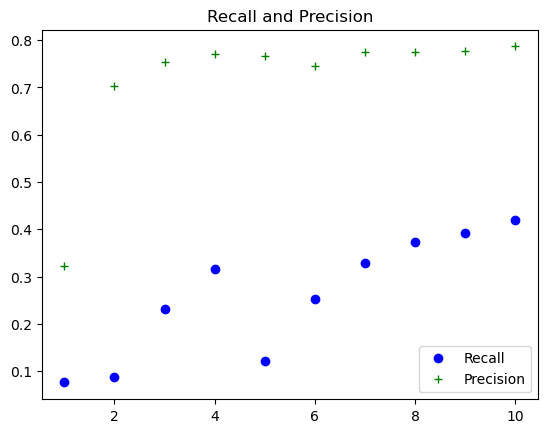

In [10]:

plot_summary(cnn_lstm.history)

In [14]:
cnn_lstm_model = load_model('seizure_CNN_LSTM.keras')


In [23]:
print(f"Test accuracy {cnn_lstm_model.evaluate(val_balanced_signals, val_balanced_labels, verbose=1)}")

111/111 [==============================] - 0s 4ms/step - loss: 0.6659 - accuracy: 0.6672
Test accuracy [0.66585373878479, 0.6672306656837463]


### References

[1] Badea A., Adam, A. 2021. CHB-MIT-Subdataset, EEG Seizure Analysis Dataset. Available from https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset [Accessed 12 November 2024].

[5] Panch, T. (2019). Key challenges for delivering clinical impact with artificial intelligence. BMC Medicine, 17, pp. 1-10.

[10] Rajkomar, A. (2023). Revolutionizing healthcare: the role of artificial intelligence in clinical practice. BMC Medical Education, 23, pp. 1-15.

[29] [16] Wang, C., Zou, J.Z., Zhang, J., Chen, L.L., & Wang, M. (2011). Recognition of Epileptic EEG Using Support Vector Machines. In Wang, R. & Gu, F. (eds) Advances in Cognitive Neurodynamics (II), Chapter 4, pp. 453-459. Springer, Dordrecht.
